In [ ]:
# %load_ext autoreload
# %autoreload 2

In [1]:
from comet_ml import Experiment
experiment = Experiment(project_name="physics_1d", workspace="shir994")

COMET INFO: old comet version (1.0.51) detected. current: 1.0.55 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shir994/physics-1d/a5602f0a41f84e04b1652096de7fdb83



In [2]:
%env CUDA_VISIBLE_DEVICES=0
%env LIBRARY_PATH=/usr/local/cuda/lib64

env: CUDA_VISIBLE_DEVICES=0
env: LIBRARY_PATH=/usr/local/cuda/lib64


In [19]:
import os
import sys
sys.path.append("..")
sys.path.append("../..")

In [4]:
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

import numpy as np
from tqdm import trange

import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda", 0)
%matplotlib inline

my_cmap = plt.cm.jet
my_cmap.set_under('white')

In [5]:
df = pd.read_csv("simple_surr.csv", index_col=0)
df = df.sample(frac=1)

In [6]:
df.head()

,start_px,start_py,start_pz,pid,hit_x,hit_y,hit_z,magn_len,start_theta,start_phi,start_P
5779,0.168870,0.537594,8.433587,-13.0,-268.310394,147.968033,-13000.0,5.0,0.066716,1.266435,8.452391
9789,0.082548,-0.288494,7.888186,-13.0,-120.654259,-84.459557,-13000.0,2.0,0.038022,-1.292109,7.893891
14250,0.044096,-0.029537,9.005111,13.0,605.092896,-8.966905,-13000.0,12.0,0.005894,-0.590197,9.005267
884,0.332521,-0.517492,7.260886,13.0,185.995667,-163.875076,-13000.0,1.0,0.084515,-0.999667,7.286894
24355,-0.292245,-0.259529,5.190126,13.0,290.443329,-115.915115,-13000.0,4.0,0.075164,-2.415417,5.204822


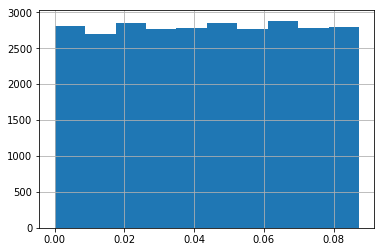

In [12]:
df.start_theta.hist()

In [37]:
data_columns = ["hit_x", "hit_y"]
inputs_columns = ["pid", "start_theta", "start_phi", "start_P", "magn_len"]

In [38]:
data = torch.Tensor(df[data_columns].to_numpy(dtype=np.float32)).to(device)
inputs = torch.Tensor(df[inputs_columns].to_numpy(dtype=np.float32)).to(device)

# Model

In [9]:
class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim, hidden_dim=100, input_param=5):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(noise_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, out_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)

    def forward(self, z, params):
        """
            Generator takes a vector of noise and produces sample
        """
        #z = torch.cat([z, params.repeat(z.shape[0], 1)], dim=1)
        z = torch.cat([z, params], dim=1)
        h1 = torch.tanh(self.fc1(z))
        h2 = F.leaky_relu(self.fc2(h1))
        y_gen = self.fc3(h2)
        return y_gen
    
class Discriminator(nn.Module):
    def __init__(self, in_dim, hidden_dim=100, input_param=2):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(in_dim + input_param, hidden_dim)
        nn.init.xavier_normal_(self.fc1.weight)
        nn.init.constant_(self.fc1.bias, 0.0)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc2.weight)
        nn.init.constant_(self.fc2.bias, 0.0)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        nn.init.xavier_normal_(self.fc3.weight)
        nn.init.constant_(self.fc3.bias, 0.0)
        
        self.fc4 = nn.Linear(hidden_dim, 1)
        nn.init.xavier_normal_(self.fc4.weight)
        nn.init.constant_(self.fc4.bias, 0.0)

    def forward(self, x, params):
        x = torch.cat([x, params], dim=1)
        h1 = torch.tanh(self.fc1(x))
        h2 = F.leaky_relu(self.fc2(h1))
        h3 = F.leaky_relu(self.fc3(h2))
        score = torch.sigmoid(self.fc4(h3))
        return score

In [20]:
hyper_params = {
    'TASK': 2,
    "batch_size": 64,
    "NOISE_DIM": 50,
    "num_epochs": 1000,
    "learning_rate": 0.0001,
    "n_d_train": 5,
    "INST_NOISE_STD": 0.3,
    "INSTANCE_NOISE": False,
    "param_dim": 1,
    "x_dim": 4
}
experiment.log_parameters(hyper_params)
INSTANCE_NOISE = hyper_params['INSTANCE_NOISE']
TASK = hyper_params['TASK']

from gan import GANLosses
from utils import iterate_minibatches
PATH = "./physics_gan.tar"

In [45]:
generator = Generator(hyper_params['NOISE_DIM'], 2, hidden_dim=100,
          input_param=hyper_params['param_dim'] + hyper_params['x_dim']).to(device)
discriminator = Discriminator(in_dim=2, hidden_dim=100,
              input_param=hyper_params['param_dim'] + hyper_params['x_dim']).to(device)

g_optimizer = optim.Adam(generator.parameters(),     lr=hyper_params['learning_rate'], betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=hyper_params['learning_rate'], betas=(0.5, 0.999))

In [46]:
def sample_noise(N, NOISE_DIM):
    return np.random.normal(size=(N,NOISE_DIM)).astype(np.float32)

def draw_hitmap(n_samples=100):
    f = plt.figure(figsize=(21,16))
    for index in range(16):
        plt.subplot(4,4, index + 1)
        theta = torch.empty(size=[n_samples,1]).uniform_(df.start_theta.min(), df.start_theta.max())
        phi = torch.empty(size=[n_samples,1]).uniform_(df.start_phi.min(), df.start_phi.max())
        p = torch.empty(size=[n_samples,1]).uniform_(df.start_P.min(), df.start_P.max())

        pids = torch.distributions.Bernoulli(probs=0.5).sample([n_samples, 1])
        pids[pids == 1] = 13.
        pids[pids == 0] = -13.

        magn_len = torch.empty(size=[1, 1], dtype=torch.float32).uniform_(1, 15).repeat([n_samples, 1])


        noise = torch.Tensor(sample_noise(n_samples, hyper_params['NOISE_DIM'])).to(device)
        distr = generator(noise, torch.cat([pids, theta, phi, p, magn_len], dim=1).to(device)).detach().cpu().numpy()

        plt.hist2d(distr[:,0], distr[:, 1], bins=50, cmap=my_cmap, cmin=1e-10, normed=True)
        plt.grid()
        plt.colorbar()
        plt.title("len={:.2f}".format(magn_len[0,0].item()), fontsize=15)
    return f

In [47]:
def run_training():

    # ===========================
    # IMPORTANT PARAMETER:
    # Number of D updates per G update
    # ===========================
    k_d, k_g = hyper_params["n_d_train"], 1

    gan_losses = GANLosses(TASK, device)

    try:
        with experiment.train():
            for epoch in range(hyper_params['num_epochs']):
                dis_epoch_loss = []
                gen_epoch_loss = []

                for input_data, inputs_batch in iterate_minibatches(data, hyper_params['batch_size'], y=inputs):
                    # Optimize D
                    for _ in range(k_d):
                        # Sample noise
                        noise = torch.Tensor(sample_noise(len(input_data), hyper_params['NOISE_DIM'])).to(device)

                        # Do an update
                        inp_data = input_data.to(device)
                        data_gen = generator(noise, inputs_batch)

                        if INSTANCE_NOISE:
                            inp_data += torch.distributions.Normal(0,hyper_params['INST_NOISE_STD']).\
                                        sample(inp_data.shape).to(device)
                            data_gen += torch.distributions.Normal(0, hyper_params['INST_NOISE_STD']).\
                                        sample(data_gen.shape).to(device)

                        loss = gan_losses.d_loss(discriminator(data_gen, inputs_batch),
                                                discriminator(inp_data, inputs_batch))
                        if TASK == 4:
                            grad_penalty = gan_losses.calc_gradient_penalty(discriminator,
                                                                            data_gen.data,
                                                                            inputs_batch.data,
                                                                            inp_data.data)
                            loss += grad_penalty

                        if TASK == 5:
                            grad_penalty = gan_losses.calc_zero_centered_GP(discriminator,
                                                                            data_gen.data,
                                                                            inputs_batch.data,
                                                                            inp_data.data)
                            loss -= grad_penalty                            

                        d_optimizer.zero_grad()
                        loss.backward()
                        d_optimizer.step()

                        if TASK == 3:                    
                            for p in discriminator.parameters():
                                p.data.clamp_(clamp_lower, clamp_upper)
                    dis_epoch_loss.append(loss.item())

                    # Optimize G
                    for _ in range(k_g):
                        # Sample noise
                        noise = torch.Tensor(sample_noise(len(input_data), hyper_params['NOISE_DIM'])).to(device)

                        # Do an update
                        data_gen = generator(noise, inputs_batch)
                        if INSTANCE_NOISE:
                            data_gen += torch.distributions.Normal(0, hyper_params['INST_NOISE_STD']).\
                                        sample(data_gen.shape).to(device)
                        loss = gan_losses.g_loss(discriminator(data_gen, inputs_batch))
                        g_optimizer.zero_grad()
                        loss.backward()
                        g_optimizer.step()
                    gen_epoch_loss.append(loss.item())
                
                experiment.log_metric("d_loss", np.mean(dis_epoch_loss), step=epoch)
                experiment.log_metric("g_loss", np.mean(gen_epoch_loss), step=epoch)
                
                
                if epoch % 20 == 0:
                    f = draw_hitmap(n_samples=2000)
                    experiment.log_figure("hitmap_{}".format(epoch), f)
                    plt.close(f)
                    
                    
                    torch.save({
                        'gen_state_dict': generator.state_dict(),
                        'dis_state_dict': discriminator.state_dict(),
                        'genopt_state_dict': g_optimizer.state_dict(),
                        'disopt_state_dict': d_optimizer.state_dict(),
                        'epoch': epoch
                        }, PATH)
                    experiment.log_asset(PATH, overwrite=True)
                
    except KeyboardInterrupt:
        pass

In [48]:
run_training()